# Assignment 2
# Ling Fei Zhang, 260985358
# Brandon Ma, 260983550

## Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import SARSA
import time
import gymnasium as gym
import random
from tqdm import tqdm

c:\Users\Ling0\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here, we will set a few parameters for our environment.

In [2]:
ALPHAS = [0.1, 0.3, 0.6]
GAMMA = 0.9
TEMPERATURE = [5, 50, 100]
EPISODES = 5500
SEEDS = np.arange(10)

Driver Code to test out the combination of each alpha with each temperature for SARSA.

In [3]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False)
env.reset()
sarsa = SARSA(env, 0.1, 1, GAMMA, 10000, False)
sarsa.simulate_episodes()
final_policy = sarsa.learned_policy
print("final policy:\n", final_policy.reshape(4,4)) #tabular format to better visualize
train_reward = sarsa.train_reward()
test_reward = sarsa.test_reward()
print(f"self rewards: {sarsa.reward}")
print(f"training reward: {train_reward}")
print(f"testing reward: {test_reward}")


# print("total reward: ", rewards)

#uncomment this line if you want to vizualize the game
# sarsa.visualize(10)

100%|██████████| 10000/10000 [00:02<00:00, 4415.46it/s]


final policy:
 [[1. 2. 1. 0.]
 [1. 1. 1. 0.]
 [2. 1. 1. 1.]
 [2. 2. 2. 3.]]
self rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
training reward: 0.0
testing reward: 1.0


KeyboardInterrupt: 

### Effect of parameters on final training performance for SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_5124\3287658805.py:6: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|██████████| 3/3 [01:53<00:00, 37.72s/it]


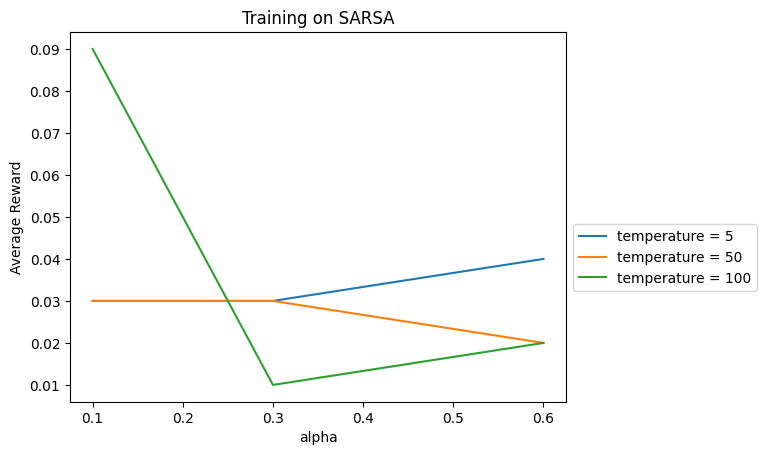

In [7]:
for temp in tqdm(TEMPERATURE):
    rewards_train = []
    for alpha in ALPHAS:
        average_reward_train = 0
        for seed in SEEDS:
            random.seed(seed)
            
            env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
            env.reset()
            sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES, False)
            sarsa.simulate_episodes()
            final_policy = sarsa.learned_policy
            train_reward = sarsa.train_reward()
            average_reward_train += train_reward
            
        average_reward_train = average_reward_train/10
        rewards_train.append(average_reward_train)
        
    # for (a, r) in zip(ALPHAS, rewards_train):
    #     print(f"temperature {temp}: {(a,r)}")
    plt.plot(ALPHAS, rewards_train, label = f"temperature = {temp}")

plt.legend(bbox_to_anchor = (1, 0.5), loc = "best")
plt.title("Training on SARSA")
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.show()

### Effect of parameters on final testing performance for SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_26932\3279100222.py:6: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|██████████| 3/3 [01:58<00:00, 39.44s/it]


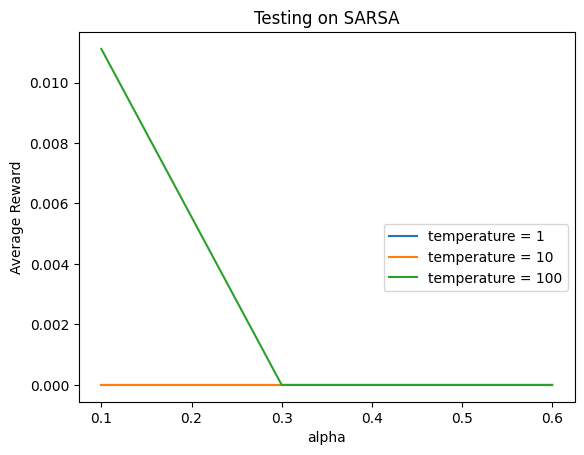

In [15]:
for temp in tqdm(TEMPERATURE):
    rewards_test = []
    for alpha in ALPHAS:
        average_reward_test = 0
        for seed in SEEDS:
            random.seed(seed)
            
            env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False)
            env.reset()
            sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES, False)
            sarsa.simulate_episodes()
            final_policy = sarsa.learned_policy
            test_reward = sarsa.test_reward()
            average_reward_test += test_reward
            
        average_reward_test = average_reward_test/10
        rewards_test.append(average_reward_test)
        
    # for (a, r) in zip(ALPHAS, rewards_test):
    #     print(f"temperature {temp}: {(a,r)}")
    plt.plot(ALPHAS, rewards_test, label = f"temperature = {temp}")

plt.legend(bbox_to_anchor = (1, 0.5), loc = "best")
plt.title("Testing on SARSA")
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.show()

### Best parameter for SARSA

### Conclusion for SARSA

### Effect of parameters on final training performance for EXPECTED SARSA

### Effect of parameters on final testing performance for EXPECTED SARSA

### Best parameter for EXPECTED SARSA

### Conclusion for EXPECTED SARSA